<a href="https://colab.research.google.com/github/Soilverts/face-recognization/blob/main/prj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sn
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow import optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Global Variables

In [ ]:
rndSeed = 57
BATCH_SIZE = 128

### Function Definitions

In [ ]:
# Function definitions

def plot_confusion_matrix(y_true, y_classified, labels, classifier):
  # Compute confusion matrix
  c_mat = np.zeros((len(labels), len(labels)))
  for i in range(len(y_true)):
    c_mat[y_true[i], y_classified[i]] += 1

  group_counts = ["{0:0.0f}".format(value) for value in c_mat.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in c_mat.flatten()/np.sum(c_mat)]
  labels_fmt = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
  labels_fmt = np.asarray(labels_fmt).reshape(c_mat.shape[0], c_mat.shape[1])

  plt.figure(figsize=(12,10))
  sn.heatmap(c_mat, annot=labels_fmt, xticklabels=labels, yticklabels=labels, fmt='', cmap='rocket_r')
  plt.title(classifier + " Confusion Matrix")
  plt.ylabel('True Class')
  plt.xlabel('Predicted Class')

# 1. Load DataSet

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ECE 539/Project/fer2013.csv')
print("shape:", df.shape)
df.head()

shape: (35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


The 1st column is emotion, it has 7 kinds of value, indicate 7 kinds of emotion.

The 2nd column is an 2304 array, indicate a 48 x 48 image

The 3rd column is usage

In this project, we only care about 1st and 2nd columns


### data overview

total pixel of image: 2304
emotions list:  ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']
Number of Images:  35887 



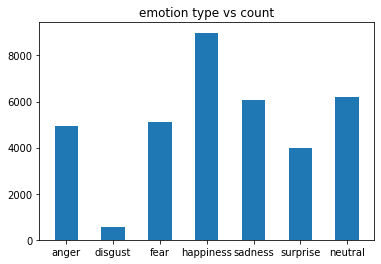

In [ ]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
print("total pixel of image:", len(df.pixels[0].split(' ')))

# emotions list
emotions = []
for e in emotion_label_to_text:
  emotions.append(emotion_label_to_text[e])
print('emotions list: ', emotions)

# Number of Images
num_of_images = np.sum(df.emotion.value_counts().sort_index(ascending=True).values)
print('Number of Images: ', num_of_images, '\n')

plt.bar(emotions, df.emotion.value_counts().sort_index(ascending=True).values, align='center', width=0.5) # Correction 
plt.title("emotion type vs count")
plt.show()
print()

### convert data into numpy array

In [ ]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)
print(img_array.shape)

img_features = []
# convert 1-D image to 3-D image list
for i in range(len(img_array)):
    img_features.append(cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB))

print(np.array(img_features).shape)

# Data Preprocessing 
# convert 3-D image list to normalized 3D numpy array
img_features = np.array(img_features) / 255
print(img_features.shape)

(35887, 48, 48)
(35887, 48, 48, 3)
(35887, 48, 48, 3)


### show some of the image

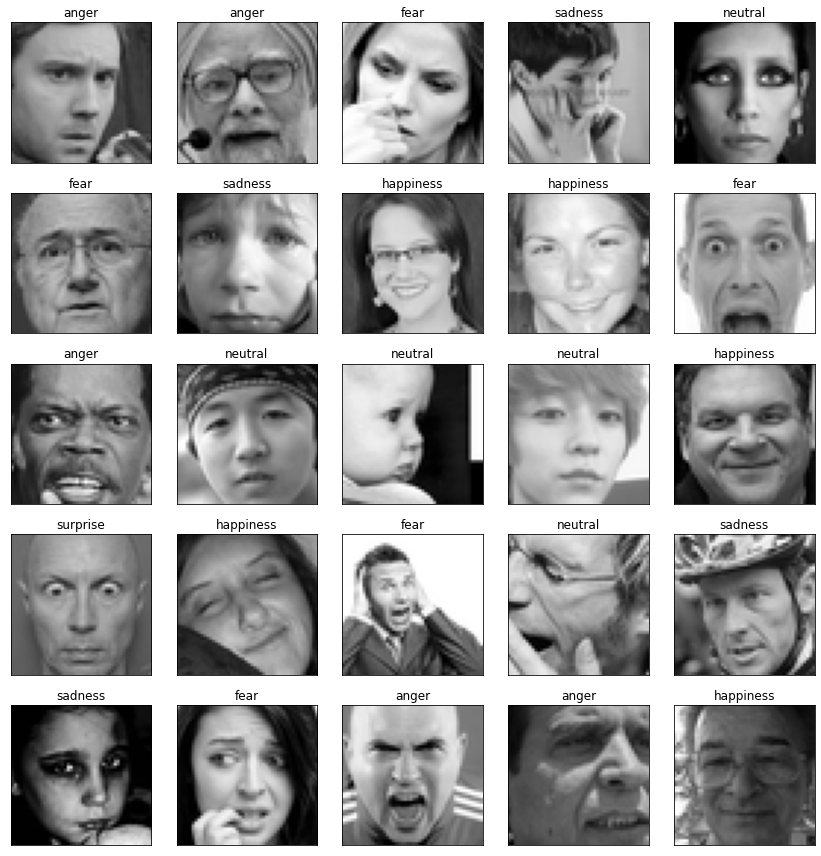

In [ ]:
plt.figure(1, (12, 12))
for j in range(25):
    ax = plt.subplot(5, 5, j + 1)
    ax.imshow(img_features[j], cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[df.emotion[j]])
    plt.tight_layout()

### one hot the label

In [ ]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
print(img_labels.shape, '\n')

# Display for confirmation (aligns with the first row of the images above)
for x in img_labels[:5]:
  z = list(x)
  for i,_ in enumerate(x):
    if x[i]:
      z[i] = emotion_label_to_text[i]
      print(z)

(35887, 7) 

['anger', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
['anger', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 'fear', 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 'sadness', 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 'neutral']


### save data into npy format

In [ ]:
np.savez("fac", img_features=img_features, img_labels=img_labels)

=====================================================================================================

### load npy data

(35887, 48, 48, 3)
(35887, 7)


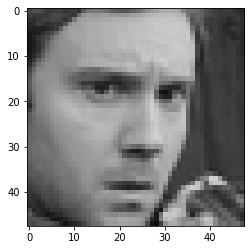

In [ ]:
ar = np.load("fac.npz")
img_features, img_labels = ar["img_features"], ar["img_labels"]

print(img_features.shape)
print(img_labels.shape)

plt.imshow(img_features[0])


### Sort Image data by emotions 

In [ ]:
# emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'} (defined already)

# Partition images based on emotion classification
img_features_partition = {}
for label in emotion_label_to_text:
  img_features_partition[label] = img_features[label == df.emotion.values]

# Print shapes of emotions
percentages = []
print('Emotion Image Shapes')
for i in img_features_partition:
  print("{:10}: {}".format(emotion_label_to_text[i], img_features_partition[i].shape))
  percentages.append((img_features_partition[i].shape[0] * 100) / num_of_images)

print('\nEmotion Percentages')

for i, p in enumerate(percentages):
  print("{:10}: {}".format(emotion_label_to_text[i], p))

Emotion Image Shapes
anger     : (4953, 48, 48, 3)
disgust   : (547, 48, 48, 3)
fear      : (5121, 48, 48, 3)
happiness : (8989, 48, 48, 3)
sadness   : (6077, 48, 48, 3)
surprise  : (4002, 48, 48, 3)
neutral   : (6198, 48, 48, 3)

Emotion Percentages
anger     : 13.801655195474684
disgust   : 1.524228829381113
fear      : 14.269791289324825
happiness : 25.048067545350683
sadness   : 16.93370858528158
surprise  : 11.151670521358708
neutral   : 17.270878033828406


### Split into train data and validation data w.r.t emotion distribution

In [ ]:
train_size = 0.9
val_size = 0.1

X_train, X_val, y_train, y_val = train_test_split(
    img_features, img_labels, shuffle=True, 
    stratify=img_labels, test_size=val_size, random_state=rndSeed)

num_of_images_train = X_train.shape[0]
num_of_images_val = X_val.shape[0]

print('X shapes: ', X_train.shape, X_val.shape, '\n')
print('y shapes: ', y_train.shape, y_val.shape, '\n')
print('{:20}: '.format('num_of_images_train'), num_of_images_train)
print('{:20}: '.format('num_of_images_val'), num_of_images_val)


X shapes:  (32298, 48, 48, 3) (3589, 48, 48, 3) 

y shapes:  (32298, 7) (3589, 7) 

num_of_images_train :  32298
num_of_images_val   :  3589


### Confirm Proportions are maintained

In [ ]:
# Get emotions of partitioned data
train_emotions = np.argmax(y_train, axis=1)
val_emotions = np.argmax(y_val, axis=1)

print(train_emotions, '\n')

percentages = {'train': [], 'val': []}

# Get percentages of (train, test & val) partitions
for label in emotion_label_to_text:
  percentages['train'].append((train_emotions[label == train_emotions].size * 100) / num_of_images_train)
  percentages['val'].append((val_emotions[label == val_emotions].size * 100) / num_of_images_val)
  
# Print percentages of partitions 
print('Emotion percentages')
for k in percentages.keys():
  print('{:5}'.format(k), ': ', percentages[k])

[3 3 0 ... 3 6 4] 

Emotion percentages
train :  [13.802712242244102, 1.5233141370982723, 14.270233450987677, 25.047990587652485, 16.93293702396433, 11.152393337048734, 17.270419221004396]
val   :  [13.792142658122039, 1.5324602953468933, 14.265812203956534, 25.04876010030649, 16.940651992198383, 11.145165784341042, 17.275006965728615]


In [ ]:
# Delete to prevent mistakes

del df
del img_features
del img_labels

In [ ]:
_, img_width, img_height, img_depth = X_train.shape
_, num_classes = y_train.shape

print('Image dimensions: ', img_width, 'x', img_height, 'x',img_depth)
print('Number of classes: ', num_classes)

Image dimensions:  48 x 48 x 3
Number of classes:  7


## 2. Create data flow

(128, 48, 48, 3)
(128, 7)


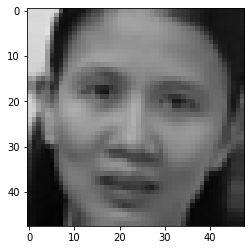


(128, 48, 48, 3)
(128, 7)


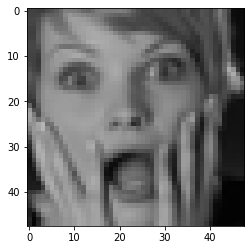


(128, 48, 48, 3)
(128, 7)


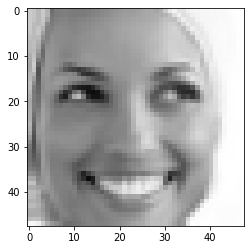

In [ ]:
# data prep
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    fill_mode='nearest')

# Training generator
train_generator = datagen.flow(
    X_train,
    y_train,
    batch_size=BATCH_SIZE) # BATCH_SIZE = 128

# Validation generator
validation_generator = datagen.flow(
    X_val,
    y_val,
    batch_size=BATCH_SIZE)

# show 3 piece of data
for i in range(3):
    xs,ys = next(train_generator)
    print(xs.shape)
    print(ys.shape)
    plt.imshow(xs[0])
    plt.show()
    print()

## 3. Prepare for Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0

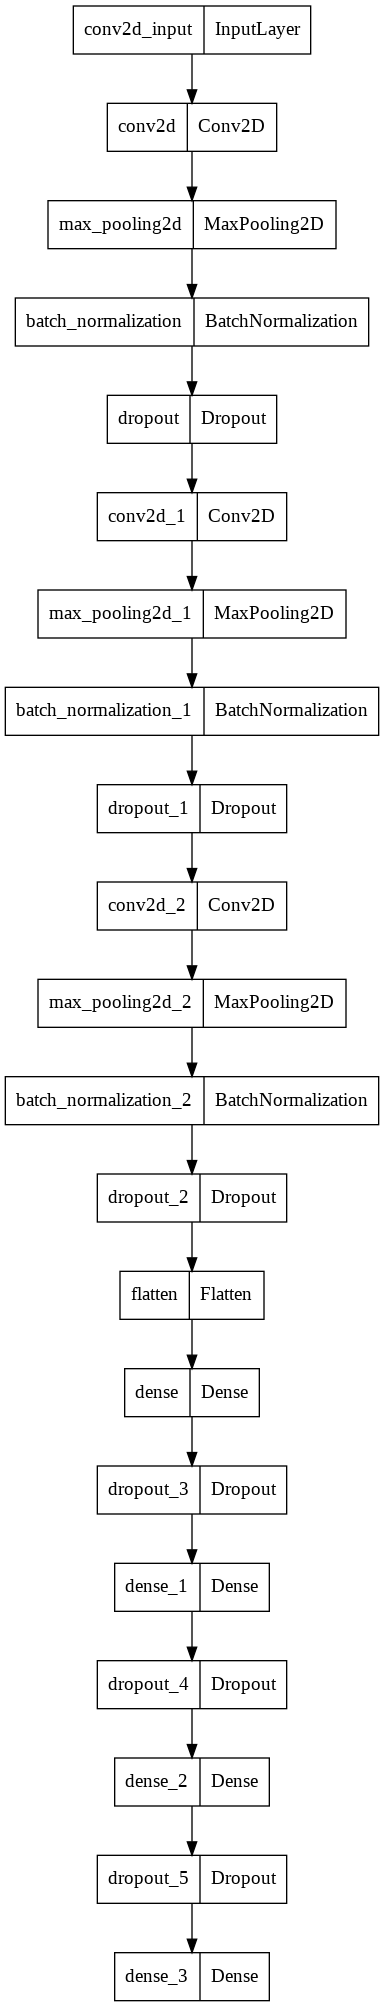

In [ ]:
DROPOUT_RATE = 0.4

model = tf.keras.models.Sequential([
    
    # filter the image for 1st time
    tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same',input_shape=(48,48,3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    
    # filter the image for 2nd time
    tf.keras.layers.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    
    # filter the image for 3rd time
    tf.keras.layers.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    
    # convert 3D - 1D
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(DROPOUT_RATE),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer = optimizers.RMSprop(learning_rate=0.0001, decay=1e-6),
              metrics=['accuracy'])
model.summary()
tf.keras.utils.plot_model(model)

# 4. Train the model

In [ ]:
# Calculate the steps per epoch to ensure there are enough images per training/validation batch
TRAIN_STEPS_PER_EPOCH = np.ceil((num_of_images_train / BATCH_SIZE)-2)

VAL_STEPS_PER_EPOCH = np.ceil((num_of_images_val / BATCH_SIZE)-2)

In [ ]:
# Add call backs
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=8,
    verbose=1,
    mode='max', # when val_accuracy stops increasing
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint(
    'best_model.h5', 
    monitor='val_accuracy', 
    mode='max', 
    verbose=1, 
    save_best_only=True
)

callbacks = [
    early_stopping,
    model_checkpoint
]

In [ ]:
history=model.fit(
    train_generator,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    epochs=70,
    validation_data=validation_generator,
    validation_steps=TRAIN_STEPS_PER_EPOCH,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/70
251/251 [==============================] - ETA: 0s - loss: 1.2643 - accuracy: 0.5215
Epoch 1: val_accuracy improved from -inf to 0.52848, saving model to best_model.h5
251/251 [==============================] - 39s 155ms/step - loss: 1.2643 - accuracy: 0.5215 - val_loss: 1.2635 - val_accuracy: 0.5285
Epoch 2/70
251/251 [==============================] - ETA: 0s - loss: 1.2602 - accuracy: 0.5227
Epoch 2: val_accuracy did not improve from 0.52848
251/251 [==============================] - 38s 152ms/step - loss: 1.2602 - accuracy: 0.5227 - val_loss: 1.4996 - val_accuracy: 0.4644
Epoch 3/70
251/251 [==============================] - ETA: 0s - loss: 1.2532 - accuracy: 0.5303
Epoch 3: val_accuracy improved from 0.52848 to 0.55481, saving model to best_model.h5
251/251 [==============================] - 38s 150ms/step - loss: 1.2532 - accuracy: 0.5303 - val_loss: 1.2114 - val_accuracy: 0.5548
Epoch 4/70
251/251 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0

### Note: Only use to retrieve best model in case of error

In [ ]:
# saved_model = load_model('best_model.h5')

### Save model

In [ ]:
model.save("model_pr1_1.h5")
model = tf.keras.models.load_model("model_pr1_1.h5")

## 5. Evaluate

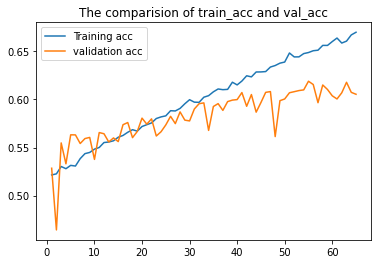

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
 
epochs=range(1,len(acc)+1)
plt.figure("acc")
plt.plot(epochs,acc,'-',label='Training acc')
plt.plot(epochs,val_acc,'',label='validation acc')
plt.title('The comparision of train_acc and val_acc')
plt.legend()
plt.show()

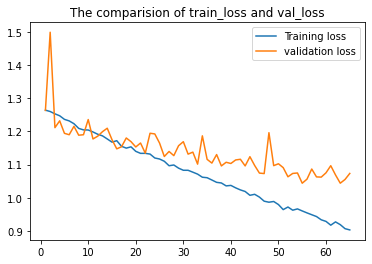

In [ ]:
plt.figure("loss")
plt.plot(epochs,loss,'-',label='Training loss')
plt.plot(epochs,val_loss,'',label='validation loss')
plt.title('The comparision of train_loss and val_loss')
plt.legend()
plt.show()

In [ ]:
print('The model with the maximum validation accuracy has an accuracy of: ', np.max(val_acc))

The model with the maximum validation accuracy has an accuracy of:  0.6189314126968384


In [ ]:
# col[0] = pred, col[1] = base truth
y_arr = [[], []]

for i in range(20): # BATCH_SIZE = 128
  
  # generate batch
  X_sample, y_sample = next(validation_generator) 
  y_sample = np.argmax(y_sample, axis=1)

  # Predict model
  y_pred = np.argmax(model.predict(X_sample), axis=1)

  if not i:
    y_arr[0] = y_pred
    y_arr[1] = y_sample # truth
    continue

  y_arr = np.append(y_arr, np.array([y_pred, y_sample]), axis=1)

y_arr = np.array(y_arr)
y_arr.shape

(2, 2560)

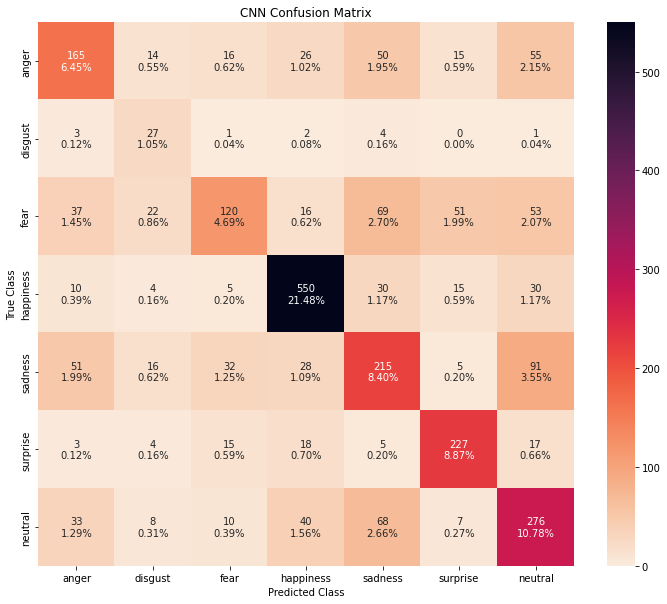

In [ ]:
plot_confusion_matrix(
    y_true = y_arr[1], 
    y_classified = y_arr[0], 
    labels = emotions, 
    classifier = "CNN")

In [ ]:
acc_score = accuracy_score(
    y_true = y_arr[1], 
    y_pred = y_arr[0], 
)

In [ ]:
print('The accuracy of the model is: ', acc_score)

The accuracy of the model is:  0.6171875


In [ ]:
drive.flush_and_unmount()